# Greenhouse gas benefit from avoided slashpile burning
### British Columbia's Forest Carbon Initiative

Robbie Hember (Robert.Hember@gov.bc.ca)

Climate Change and Integrated Planning Branch

BC Ministry of Forests, Lands, Natural Resource Operations and Rural Development

## 1. Introduction

### 1.1. Description

This project demonstrates avoided emissions.

Stand attributes: 
100% lodgepole pine, SI=18 m, planting density = 1600 sph, BGC zone = SBS.

Scenarios:

Baseline: Clearcut and slashpile burn followed by planting

Project 1: Clearcut and leave all residual fibre on site to decay followed by planting.

Project 2: Clearcut and take the majority (95%) of residual fibre for 100% bioenergy followed by planting 

Project 3: Clearcut and take the majority (95%) of residual fibre for 50% bioenergy and 50% pulp followed by planting

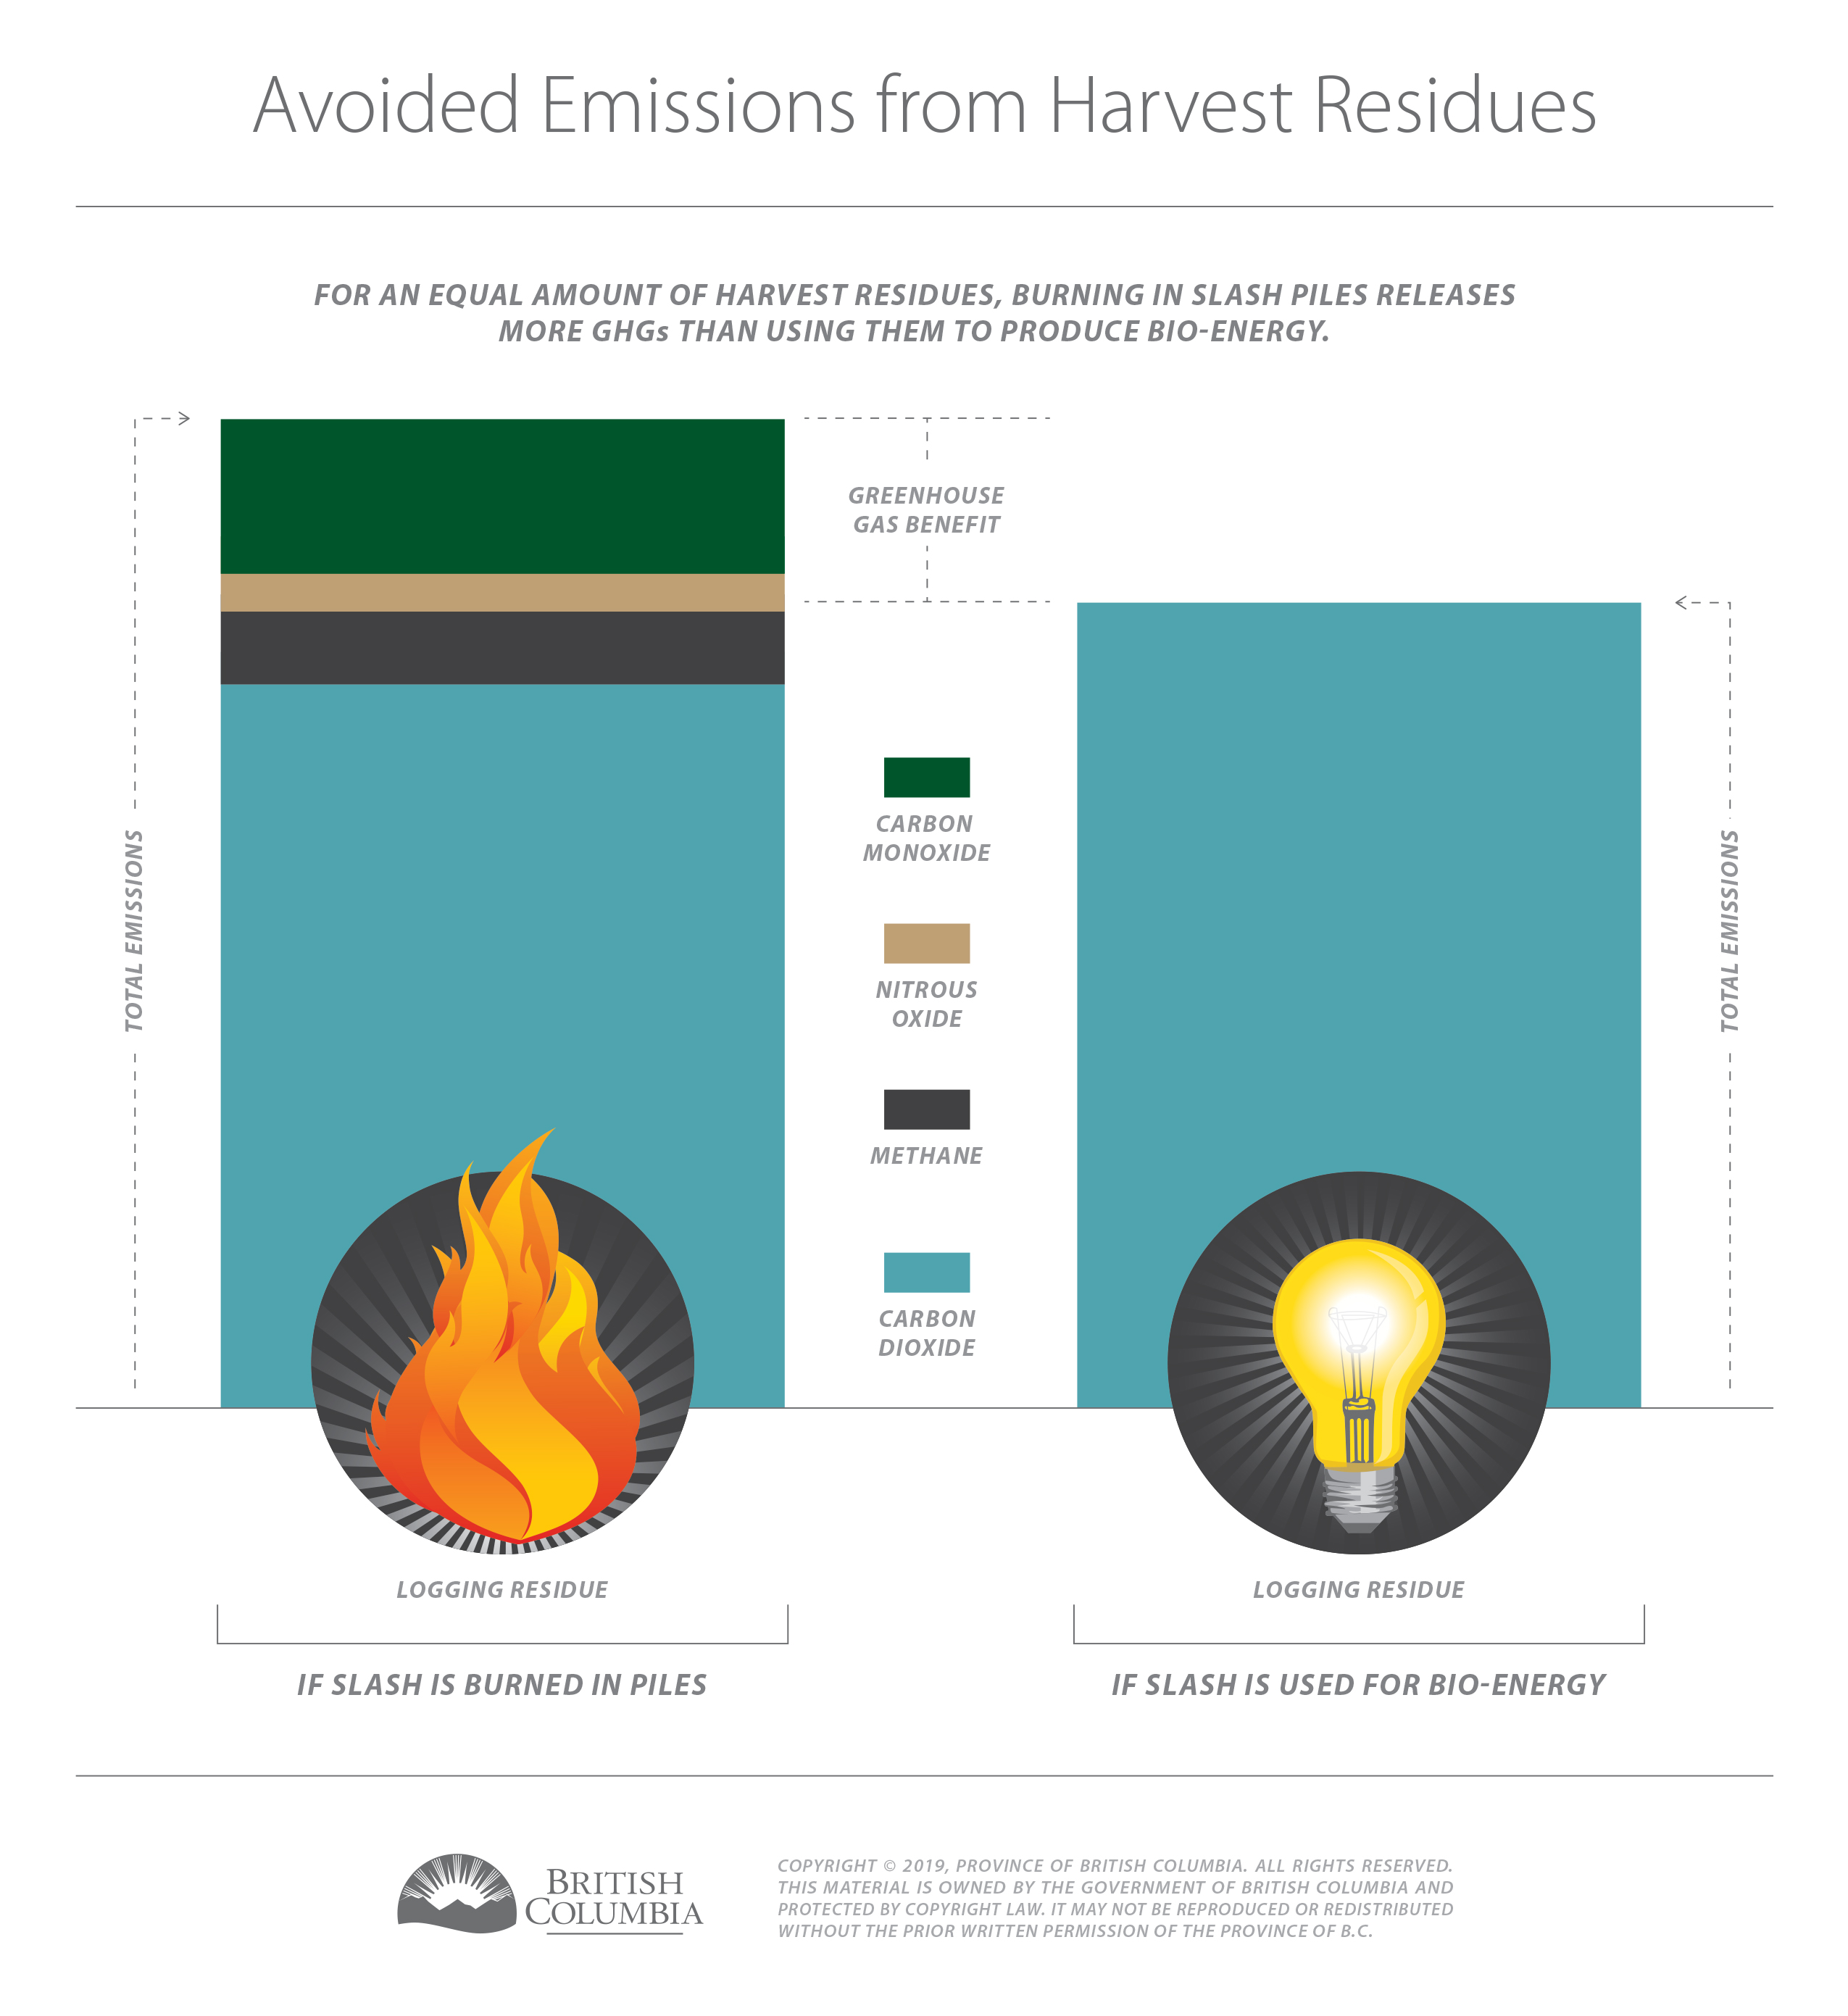

In [1]:
from IPython.display import Image
Image(r'\\sfp.idir.bcgov\s164\S63029\!Workgrp\Forest Carbon\Forest Carbon Initiative\Communications and Meetings\Information Notes\Infographics\7016_AvoidedEmissions_FLNR_HR.jpg')

## 2. Methods

### 2.1. Project log

Version 1: Saved frozen files: 2018-10-04; By Robbie; CBRunner.py R2018e; BatchTIPSY.exe 4.4; Note 1 - None.

Version 2: Saved frozen files: 2019-11-01; By Robbie; CBRunner.py R2019c; BatchTIPSY.exe 4.4; Note 1 - Updated model version, cleaned up scripting, should be no changes to results.

### 2.2. Prepare session

In [2]:
# Import python modules
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import dill

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Change cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; } .output {align-items: center; }</style>"))

# Force inline plotting
%matplotlib inline

# Set style
plt.style.use('ggplot')
#plt.style.use('default')

# Set rc properties
params={'font.sans-serif':'Arial',
        'font.size':12,
        'axes.labelsize':12,
        'axes.titlesize':14,
        'axes.linewidth':0.5,        
        'xtick.labelsize':12,
        'xtick.major.width':0.5,
        'xtick.major.size':5,
        'xtick.direction':'in',
        'ytick.labelsize':12,
        'ytick.major.width':0.5,
        'ytick.major.size':5,
        'ytick.direction':'in',
        'legend.fontsize':10,
        'savefig.dpi':150}
plt.rcParams.update(params)

In [4]:
# Configure project
meta={}
meta['Path Project']=r'C:\Users\rhember\Documents\Data\CBRunner\FCI_Demo_AvoidedEmissions'
meta['Path Model Code']=r'C:\Users\rhember\Documents\Code_Python\BCForestCarbonPy\R2019c'
meta['Time']=np.arange(1,2151,1)
meta['Year Start']=meta['Time'][0]
meta['Year End']=meta['Time'][-1]
meta['Save All Data']='On'
meta['Year Start Saving']=1850
meta['Output Format']='Dictionary'
meta['Spreadsheet Outputs']=['All']
meta['Growth Modifier']=np.ones(meta['Time'].shape)
meta['Skip Completed Runs']='Off'
meta['N Stand']=6
meta['N Scenario']=2
meta['N Ensemble']=1
meta['N Run']=''
meta['Batch Interval']=1500
meta['N Batch']=1

In [5]:
# Import CBRunner modules & tools

# Modules
os.chdir(meta['Path Model Code'])
from CBRun import *
from CBRun_Utilities import *

# look-up tables
LUT_Dist,LUT_BGC_Zone=ImportLUTs(meta['Path Model Code'])

# FCI parameters
pFCI=ImportParametersFCI(r'Z:\!Workgrp\Forest Carbon\Data')

# Load variable names
str_CustDistVars=LoadCustomDistVarNams([])

In [6]:
# Custom functions

# Create a class for unpacking dictionary contents
class Bunch(object):
    def __init__(self, adict):
        self.__dict__.update(adict)

In [7]:
# Define parameters

# Eventually I'd like all these to be read in from a central DB
cost_per_km_per_m3=0.0435729847494553 # $ (from PT V2017)
distance=80 # km (from PT V2017)

# Cost of leaving on site ($/ha, ????)
cost_los=(60+125)/2

### 2.3. Prepare yield curves from TASS/TIPSY

1) Manually define the gorwth curves that you want to run in TIPSY by parameterizing the "Define Growth Curves" spreadsheet.

In [8]:
# 2) Automatically create the formatted input file for BatchTIPSY.exe based on how the "Define Growth Curves" spreadsheet was parameterized:
BuildTIPSYInputs(meta['Path Project'] + '\\Inputs\\GrowthCurveLibrary')

0


3) Manually run TIPSY after making sure the input file is up-to-date. This should create the .out ascii file.

In [9]:
# 4) Import TASS/TIPSY results
# TIPSY exports curves as MgDM/ha/yr, CBRunner expects inputs of MgC/ha/yr - create conversion factor
dm2c=0.5

# Growth curve definitions (input variables to TIPSY) 
df_GCL=pd.read_excel(meta['Path Project'] + '\\Inputs\\GrowthCurveLibrary\\GrowthCurveLibrary_TIPSY_DefineRuns.xlsx',sheetname='Sheet1',skiprows=7)

# Growth curve data (output from TIPSY)
data=np.loadtxt(meta['Path Project'] + '\\Inputs\\GrowthCurveLibrary\\GrowthCurveLibrary_TIPSY_Output.out',skiprows=4)

# TIPSY saves to text file -> convert to dataframe (column names must match TIPSY output file design)
colnams=['Age','VolTot0','VolMerch75','VolMerch125','VolMerch175','ODT_Bark','ODT_Branch','ODT_Foliage','ODT_Roots','ODT_Stem','Lum1_2x4','Lum1_2x6','Lum1_2x8','Lum1_2x10','Lum2orBetter_2x4','Lum2orBetter_2x6','Lum2orBetter_2x8','Lum2orBetter_2x10']
data_GCL=pd.DataFrame(data,columns=colnams)

# Define age vector (must be consistent with how TIPSY was set up)
Age=np.arange(0,301,1)

# Get dimensions of the TIPSY output file to reshape the data into Age x Stand
N_Age=Age.size
N_GC=int(data_GCL.shape[0]/N_Age)
#print("Number of stands = " + str(N_Stand))
#print("Number of growth curves = " + str(N_GC))

# Merchantable stemwood volume
V_StemMerch=np.reshape(data_GCL['VolMerch125'].values,(N_Age,N_GC),order='F')
G_VStemMerch=np.append(np.zeros((1,N_GC)),np.diff(V_StemMerch,axis=0),axis=0)

# Define the fraction of merchantable stemwood
fMerch=np.nan_to_num(np.reshape(data_GCL['VolMerch125'].values,(N_Age,N_GC),order='F')/np.reshape(data_GCL['VolTot0'].values,(N_Age,N_GC),order='F'))
fNonMerch=1-fMerch

# Extract age responses for each biomass pool
C_Stem=dm2c*np.reshape(data_GCL['ODT_Stem'].values,(N_Age,N_GC),order='F')
C_StemMerch=fMerch*C_Stem
C_StemNonMerch=fNonMerch*C_Stem
C_Foliage=dm2c*np.reshape(data_GCL['ODT_Foliage'].values,(N_Age,N_GC),order='F')
C_Branch=dm2c*np.reshape(data_GCL['ODT_Branch'].values,(N_Age,N_GC),order='F')
C_Bark=dm2c*np.reshape(data_GCL['ODT_Bark'].values,(N_Age,N_GC),order='F')

# Calculate growth
z=np.zeros((1,N_GC))
G_StemMerch=np.append(z,np.diff(C_StemMerch,axis=0),axis=0)
G_StemNonMerch=np.append(z,np.diff(C_StemNonMerch,axis=0),axis=0)
G_Foliage=np.append(z,np.diff(C_Foliage,axis=0),axis=0)
G_Branch=np.append(z,np.diff(C_Branch,axis=0),axis=0)
G_Bark=np.append(z,np.diff(C_Bark,axis=0),axis=0)

### 2.4. Run ecosystem carbon model

In [10]:
# Prepare inventory

# Initialize inventory variables
Lat=np.zeros((1,meta['N Stand']))
Lon=np.zeros((1,meta['N Stand']))
X=Lat
Y=Lon
ID_Spc1=27*np.ones((1,meta['N Stand']))
Prc_Spc1=100*np.ones((1,meta['N Stand']))
SI_Spc1=-999*np.ones((1,meta['N Stand']))
ID_BECZ=-999*np.ones((1,meta['N Stand']))

# Populate BEC zone with values from TIPSY definition file
ind=0
for i in range(meta['N Stand']):
    ID_BECZ[0,i]=LUT_BGC_Zone[df_GCL['bec_zone'][ind]]
    
# Add dummy values for mean annual temperature (MAT) -> MAT will be updated based on BEC zone
MAT=4*np.ones((1,meta['N Stand']))

# Populate instance of invnetory variable structure
inv=InventoryData(Lat,Lon,X,Y,ID_Spc1,Prc_Spc1,SI_Spc1,ID_BECZ,MAT)

# Save inventory file
fout=open(meta['Path Project'] + '\\Inputs\\Inventory_Batch0.pkl','wb')
pickle.dump(inv,fout)
fout.close()

In [11]:
# Prepare disturbance history

# Define pre-industrial disturbance

# Assume stand-replacing wildfire (id=10)
ID_pi=[LUT_Dist['Wildfire'],LUT_Dist['Wildfire'],LUT_Dist['Wildfire'],LUT_Dist['Wildfire'],LUT_Dist['Wildfire'],LUT_Dist['Wildfire']]

# Assume a return interval (years) of:
RT_pi=[150,150,150,150,150,150]

# Apply the growth curve corresponding to the baseline scenario of each demonstration 
# This is the (the ID column value from "GrowthCurveLibrary_TIPSY_DefineRuns.xlsx")
ID_GrowthCurveI_pi=[1,1,1,1,1,1]

# Define modern disturbance 1

# Year -> 2018
Year_Modern1=[2018,2018,2018,2018,2018,2018]

# Age of stands when hit by the first modern disturbance
Age_Modern1=[120,120,120,120,120,120]

# Type of the first modern distubance (setting as zero will trigger the user-prescribed felling/utilization)
ID_Modern1=[0,0,0,0,0,0]

# Growth curve following first modern disturbance event
ID_GrowthCurveI_Modern1=[1,1,1,1,1,1]

# Define modern disturbance 2
Year_Modern2=[2019,2019,2019,2019,2019,2019]
ID_Modern2=[LUT_Dist['Planting'],LUT_Dist['Planting'],LUT_Dist['Planting'],LUT_Dist['Planting'],LUT_Dist['Planting'],LUT_Dist['Planting']] 
ID_GrowthCurveI_Modern2=[2,2,2,2,2,2]
# Import the felling transfer assumptions for each stand
etpt1=ImportCustomEcoToProdTrans(meta['Path Project'] + '\\Inputs\\CustomAssumptions_EcoToProdTrans_1.xlsx')
etpt2=ImportCustomEcoToProdTrans(meta['Path Project'] + '\\Inputs\\CustomAssumptions_EcoToProdTrans_2.xlsx')
etpt3=ImportCustomEcoToProdTrans(meta['Path Project'] + '\\Inputs\\CustomAssumptions_EcoToProdTrans_3.xlsx')
etpt4=ImportCustomEcoToProdTrans(meta['Path Project'] + '\\Inputs\\CustomAssumptions_EcoToProdTrans_4.xlsx')
etpt5=ImportCustomEcoToProdTrans(meta['Path Project'] + '\\Inputs\\CustomAssumptions_EcoToProdTrans_5_CantsBaseline.xlsx')
etpt6=ImportCustomEcoToProdTrans(meta['Path Project'] + '\\Inputs\\CustomAssumptions_EcoToProdTrans_6_CantsProject.xlsx')

# Define modern disturbance 3
# -> planting in the project
Year_Modern3=[0,0,0,0,0,0]
ID_Modern3=[0,0,0,0,0,0]
ID_GrowthCurveI_Modern3=[2,2,2,2,2,2]

In [12]:
# Loop through batches of project
for iEns in range(0,meta['N Ensemble']):
    # Loop through to create an Events data structure and store it in list, dh
    dh=list()
    for i in range(0,meta['N Stand']):
                
        #----------------------------------------------------------------------------------
        # Add pre-industrial disturbance year and type
        #----------------------------------------------------------------------------------
    
        Year=np.arange(Year_Modern1[i]-Age_Modern1[i]-100*RT_pi[i],Year_Modern1[i]-Age_Modern1[i]+150,RT_pi[i])
        Year=Year[np.where(Year>=meta['Time'][0])[0]]     
        m_Dist=Year.shape[0]
        ID=ID_pi[i]*np.ones(m_Dist)
        ID_GrowthCurveI=ID_GrowthCurveI_pi[i]*np.ones(m_Dist)
        
        #----------------------------------------------------------------------------------
        # Add first modern distubance event year and type
        #----------------------------------------------------------------------------------
    
        Year=np.append(Year,Year_Modern1[i])
        ID=np.append(ID,ID_Modern1[i])
        ID_GrowthCurveI=np.append(ID_GrowthCurveI,ID_GrowthCurveI_Modern1[i])
    
        #----------------------------------------------------------------------------------
        # Add second modern distubance event year and type
        #----------------------------------------------------------------------------------
    
        if Year_Modern2[i]>0:
            Year=np.append(Year,Year_Modern2[i])
            ID=np.append(ID,ID_Modern2[i])
            ID_GrowthCurveI=np.append(ID_GrowthCurveI,ID_GrowthCurveI_Modern2[i])
    
        #----------------------------------------------------------------------------------
        # Add third modern distubance event year and type
        #----------------------------------------------------------------------------------
    
        if Year_Modern3[i]>0:
            Year=np.append(Year,Year_Modern3[i])
            ID=np.append(ID,ID_Modern3[i])
            ID_GrowthCurveI=np.append(ID_GrowthCurveI,ID_GrowthCurveI_Modern3[i])
    
        # Update number of disturbances
        m_Dist=Year.shape[0]
    
        #----------------------------------------------------------------------------------
        # Add custom ecosystem to product transfer assumptions
        #----------------------------------------------------------------------------------
    
        # Initialize custom ecosystem to product transfer assumptions
        for j in range(len(str_CustDistVars)):
            exec(str_CustDistVars[j] + "=0*np.ones(m_Dist)")
    
        # Populate custom ecosystem to product transfer assumptions
        # -> Modern disturbance 2 has salvage logging
        # *** Convert percent to fraction ***
        ind=np.where(ID==0)[0]
        for j in range(len(str_CustDistVars)):
            if i==0:
                exec(str_CustDistVars[j] + "[ind]=0.01*etpt1." + str_CustDistVars[j])
            elif i==1:
                exec(str_CustDistVars[j] + "[ind]=0.01*etpt2." + str_CustDistVars[j])
            elif i==2:
                exec(str_CustDistVars[j] + "[ind]=0.01*etpt3." + str_CustDistVars[j])
            elif i==3:
                exec(str_CustDistVars[j] + "[ind]=0.01*etpt4." + str_CustDistVars[j])
            elif i==4:
                exec(str_CustDistVars[j] + "[ind]=0.01*etpt5." + str_CustDistVars[j])    
            elif i==5:
                exec(str_CustDistVars[j] + "[ind]=0.01*etpt6." + str_CustDistVars[j])        
    
        #----------------------------------------------------------------------------------
        # Add to data structure
        #----------------------------------------------------------------------------------
    
        dh.append(Events(Year,ID,ID_GrowthCurveI,Biomass_Affected_Pct, \
            Biomass_Merch_Removed_Pct,Biomass_Merch_Burned_Pct,Biomass_Merch_LeftOnSite_Pct, \
            Biomass_NonMerch_Removed_Pct,Biomass_NonMerch_Burned_Pct,Biomass_NonMerch_LeftOnSite_Pct, \
            Snags_Affected_Pct,Snags_Removed_Pct,Snags_Burned_Pct,Snags_LeftOnSite_Pct, \
            RemovedMerchToFuel_Pct,RemovedMerchToLumber_Pct,RemovedMerchToPlywood_Pct, \
            RemovedMerchToOSB_Pct,RemovedMerchToMDF_Pct,RemovedMerchToPulp_Pct, \
            RemovedMerchToFirewood_Pct,RemovedMerchToCants_Pct,RemovedNonMerchToFuel_Pct,RemovedNonMerchToLumber_Pct, \
            RemovedNonMerchToPlywood_Pct,RemovedNonMerchToOSB_Pct,RemovedNonMerchToMDF_Pct, \
            RemovedNonMerchToPulp_Pct,RemovedNonMerchToFirewood_Pct,RemovedNonMerchToCants_Pct,RemovedSnagStemToFuel_Pct, \
            RemovedSnagStemToLumber_Pct,RemovedSnagStemToPlywood_Pct,RemovedSnagStemToOSB_Pct, \
            RemovedSnagStemToMDF_Pct,RemovedSnagStemToPulp_Pct,RemovedSnagStemToFirewood_Pct,RemovedSnagStemToCants_Pct))    

    pth=meta['Path Project'] + '\\Inputs\\Ensembles\\E' + str(iEns)
    if os.path.exists(pth)==False:
        os.mkdir(pth)      
        
    # Save disturbance history to file (this had permission issues on Google Drive)
    fout=open(meta['Path Project'] + '\\Inputs\\Ensembles\\E' + str(iEns) + '\\DisturbanceHistory_Batch0.pkl','wb')
    pickle.dump(dh,fout)
    fout.close()

In [13]:
# Prepare growth curves
for k in range(3):
    
    # Calculate kth growth curves
    GVStemMerch,GCStemMerch,GCStemNonMerch,GCBark,GCBranch,GCFoliage= \
        LoadGrowthCurves(N_Age,meta['N Stand'],dh,k,df_GCL,G_VStemMerch,G_StemMerch,G_StemNonMerch,G_Bark,G_Branch,G_Foliage)
        
    # Add to growth curve data structure
    G=GrowthCurves(GVStemMerch,GCStemMerch,GCStemNonMerch,GCBark,GCBranch,GCFoliage)
        
    # Save data to file in input variables folder of project
    fout=open(meta['Path Project'] + '\\Inputs\\GrowthCurves' + str(k+1) + '_Batch0.pkl','wb')
    pickle.dump(G,fout)
    fout.close()

In [14]:
# Run ecossytem model
RunProject(meta)

In [15]:
# Import all data
fin=open(meta['Path Project'] + '\\Outputs\\Ensembles\\E0\\DataAll_Batch0.pkl','rb')
data=dill.load(fin); fin.close();
vo=Bunch(data)

In [16]:
# Import data
fin=open(meta['Path Project'] + '\\Outputs\\Ensembles\\E0\\Data_Batch0.pkl','rb')
data=pickle.load(fin); fin.close();

# Bunch the data into a data structure
v=Bunch(data)
v.tv=np.arange(meta['Year Start Saving'],meta['Year End']+1,1)
N_t=len(v.tv)

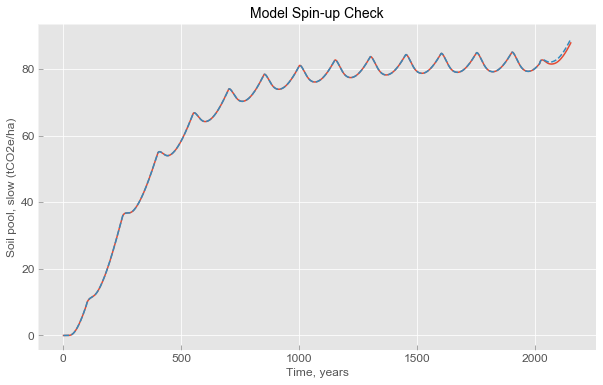

In [17]:
# Check spin up

# Confirm that the model reached dynamic equilibrium prior to the onset of the projects 
# Plot stand 0, ecosystem pool 15 (slow soil carbon pool)
fig=plt.figure(figsize=(10,6))
plt.plot(meta['Time'],vo.C_Eco_Pools[:,0,15])
plt.plot(meta['Time'],vo.C_Eco_Pools[:,1,15],'--')
plt.ylabel('Soil pool, slow (tCO2e/ha)')
plt.xlabel('Time, years');
plt.title('Model Spin-up Check');

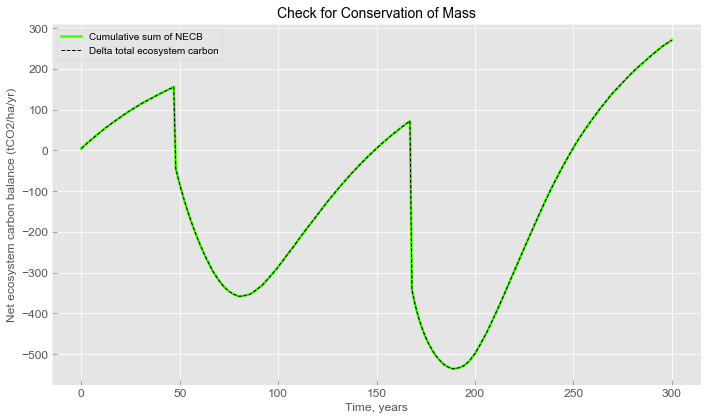

In [18]:
# Check conservation of mass

# Plot ecosystem and product sector pools
fig,ax=plt.subplots(1,figsize=(10,6))
    
# Plot cumulative net ecosystem carbon balance
ikp=np.where(meta['Time']>=meta['Year Start Saving'])[0]
E=3.667*(vo.C_CombustCO2[ikp,0]+vo.C_CombustCH4[ikp,0]+vo.C_CombustCO[ikp,0]+vo.C_CombustN2O[ikp,0])
NECB=v.Eco_NPP[:,0]-v.Eco_RH[:,0]-E-v.Eco_Removals[:,0]
y1=np.cumsum(NECB)
y2=v.Eco_Total[:,0]
d=y2[0]-y1[0]
ax.plot(y1,label='Cumulative sum of NECB',linewidth=2.5,color=[0.25,1,0])
ax.plot(y2-d,'--',label='Delta total ecosystem carbon',linewidth=1,color=[0,0,0])
ax.legend(loc='upper left')
ax.set(ylabel=r'Net ecosystem carbon balance (tCO2/ha/yr)',xlabel=r'Time, years')
ax.set_title('Check for Conservation of Mass')
plt.tight_layout();

## 3. Results

### 3.1. Impacts on pools and fluxes

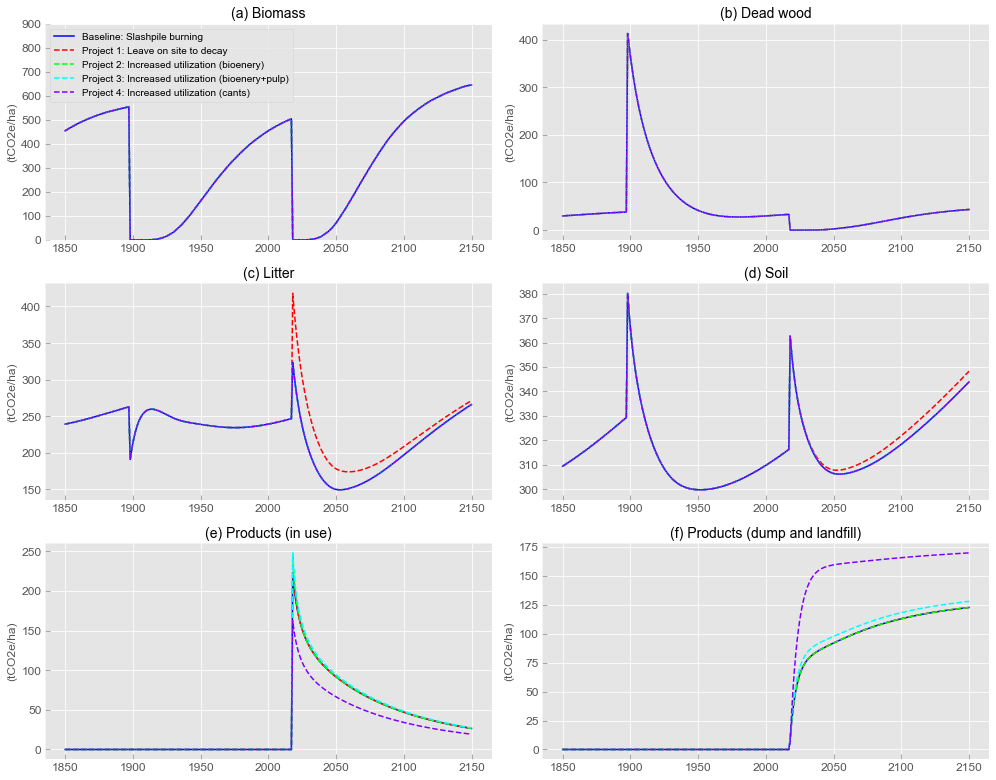

In [19]:
# Plot ecosystem and product sector pools
fig,ax=plt.subplots(3,2,figsize=(14,11))
ax[0,0].plot(v.tv,v.Eco_Biomass[:,0],'-',color=(0,0,1),label='Baseline: Slashpile burning')
ax[0,0].plot(v.tv,v.Eco_Biomass[:,1],'--',color=(1,0,0),label='Project 1: Leave on site to decay')
ax[0,0].plot(v.tv,v.Eco_Biomass[:,2],'--',color=(0,1,0),label='Project 2: Increased utilization (bioenery)')
ax[0,0].plot(v.tv,v.Eco_Biomass[:,3],'--',color=(0,1,1),label='Project 3: Increased utilization (bioenery+pulp)')
ax[0,0].plot(v.tv,v.Eco_Biomass[:,5],'--',color=(0.5,0,1),label='Project 4: Increased utilization (cants)')
ax[0,0].set_ylim(bottom=0,top=900)
ax[0,0].legend(loc="upper left", prop={'size': 10})
ax[0,0].set_title('(a) Biomass')

ax[0,1].plot(v.tv,v.Eco_DeadWood[:,0],'-',color=(0,0,1),label='Baseline')
ax[0,1].plot(v.tv,v.Eco_DeadWood[:,1],'--',color=(1,0,0),label='Project 1')
ax[0,1].plot(v.tv,v.Eco_DeadWood[:,2],'--',color=(1,1,0),label='Project 2')
ax[0,1].plot(v.tv,v.Eco_DeadWood[:,3],'--',color=(0,1,1),label='Project 3')
ax[0,1].plot(v.tv,v.Eco_DeadWood[:,5],'--',color=(0.5,0,1),label='Project 4')
ax[0,1].set_title('(b) Dead wood')

ax[1,0].plot(v.tv,v.Eco_Litter[:,0],'-',color=(0,0,1),label='Baseline')
ax[1,0].plot(v.tv,v.Eco_Litter[:,1],'--',color=(1,0,0),label='Project 1')
ax[1,0].plot(v.tv,v.Eco_Litter[:,2],'--',color=(0,1,0),label='Project 2')
ax[1,0].plot(v.tv,v.Eco_Litter[:,3],'--',color=(0,1,1),label='Project 3')
ax[1,0].plot(v.tv,v.Eco_Litter[:,5],'--',color=(0.5,0,1),label='Project 4')
ax[1,0].set_title('(c) Litter')

ax[1,1].plot(v.tv,v.Eco_Soil[:,0],'-',color=(0,0,1),label='Baseline')
ax[1,1].plot(v.tv,v.Eco_Soil[:,1],'--',color=(1,0,0),label='Project 1')
ax[1,1].plot(v.tv,v.Eco_Soil[:,2],'--',color=(0,1,0),label='Project 2')
ax[1,1].plot(v.tv,v.Eco_Soil[:,3],'--',color=(0,1,1),label='Project 3')
ax[1,1].plot(v.tv,v.Eco_Soil[:,5],'--',color=(0.5,0,1),label='Project 4')
ax[1,1].set_title('(d) Soil')

ax[2,0].plot(v.tv,v.Pro_InUse[:,0],'-',color=(0,0,1),label='Baseline')
ax[2,0].plot(v.tv,v.Pro_InUse[:,1],'--',color=(1,0,0),label='Project 1')
ax[2,0].plot(v.tv,v.Pro_InUse[:,2],'--',color=(0,1,0),label='Project 2')
ax[2,0].plot(v.tv,v.Pro_InUse[:,3],'--',color=(0,1,1),label='Project 3')
ax[2,0].plot(v.tv,v.Pro_InUse[:,5],'--',color=(0.5,0,1),label='Project 4')
ax[2,0].set_title('(e) Products (in use)')

ax[2,1].plot(v.tv,v.Pro_DumpLandfill[:,0],'-',color=(0,0,1),label='Baseline')
ax[2,1].plot(v.tv,v.Pro_DumpLandfill[:,1],'--',color=(1,0,0),label='Project 1')
ax[2,1].plot(v.tv,v.Pro_DumpLandfill[:,2],'--',color=(0,1,0),label='Project 2')
ax[2,1].plot(v.tv,v.Pro_DumpLandfill[:,3],'--',color=(0,1,1),label='Project 3')
ax[2,1].plot(v.tv,v.Pro_DumpLandfill[:,5],'--',color=(0.5,0,1),label='Project 4')
ax[2,1].set_title('(f) Products (dump and landfill)')

for i in range(3):
    for j in range(2):
        ax[i,j].set(ylabel=r'(tCO2e/ha)')
plt.tight_layout();

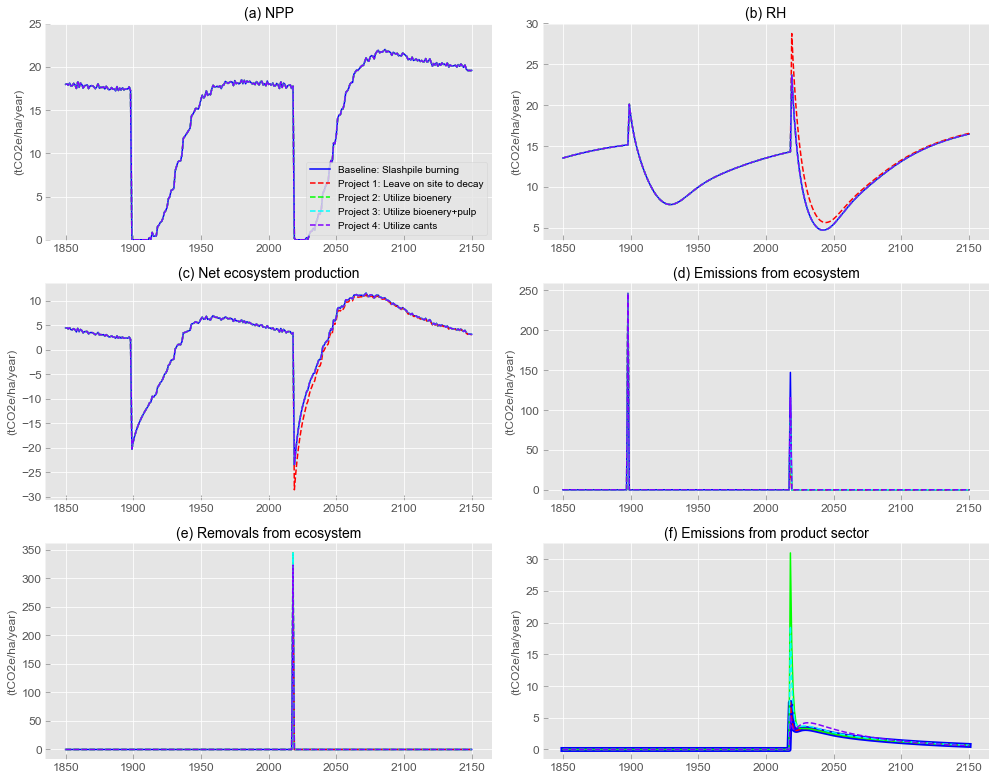

In [20]:
# Plot fluxes
fig,ax=plt.subplots(3,2,figsize=(14,11))

ax[0,0].plot(v.tv,v.Eco_NPP[:,0],'-',color=(0,0,1),label='Baseline: Slashpile burning')
ax[0,0].plot(v.tv,v.Eco_NPP[:,1],'--',color=(1,0,0),label='Project 1: Leave on site to decay')
ax[0,0].plot(v.tv,v.Eco_NPP[:,2],'--',color=(0,1,0),label='Project 2: Utilize bioenery')
ax[0,0].plot(v.tv,v.Eco_NPP[:,3],'--',color=(0,1,1),label='Project 3: Utilize bioenery+pulp')
ax[0,0].plot(v.tv,v.Eco_NPP[:,5],'--',color=(0.5,0,1),label='Project 4: Utilize cants')
ax[0,0].legend(loc="lower right", prop={'size': 10})
ax[0,0].set_ylim(bottom=0,top=25)
ax[0,0].set_title('(a) NPP')

ax[0,1].plot(v.tv,v.Eco_RH[:,0],'-',color=(0,0,1),label='Baseline')
ax[0,1].plot(v.tv,v.Eco_RH[:,1],'--',color=(1,0,0),label='Project 1')
ax[0,1].plot(v.tv,v.Eco_RH[:,2],'--',color=(0,1,0),label='Project 2')
ax[0,1].plot(v.tv,v.Eco_RH[:,3],'--',color=(0,1,1),label='Project 3')
ax[0,1].plot(v.tv,v.Eco_RH[:,5],'--',color=(0.5,0,1),label='Project 4')
ax[0,1].set_title('(b) RH')

ax[1,0].plot(v.tv,v.Eco_NPP[:,0]-v.Eco_RH[:,0],'-',color=(0,0,1),label='Baseline')
ax[1,0].plot(v.tv,v.Eco_NPP[:,1]-v.Eco_RH[:,1],'--',color=(1,0,0),label='Project')
ax[1,0].plot(v.tv,v.Eco_NPP[:,2]-v.Eco_RH[:,2],'--',color=(0,1,0),label='Project')
ax[1,0].plot(v.tv,v.Eco_NPP[:,3]-v.Eco_RH[:,3],'--',color=(0,1,1),label='Project')
ax[1,0].plot(v.tv,v.Eco_NPP[:,5]-v.Eco_RH[:,5],'--',color=(0.5,0,1),label='Project 4')
ax[1,0].set_title('(c) Net ecosystem production')

ax[1,1].plot(v.tv,v.Eco_Emissions[:,0],'-',color=(0,0,1),label='Baseline')
ax[1,1].plot(v.tv,v.Eco_Emissions[:,1],'--',color=(1,0,0),label='Project')
ax[1,1].plot(v.tv,v.Eco_Emissions[:,2],'--',color=(0,1,0),label='Project')
ax[1,1].plot(v.tv,v.Eco_Emissions[:,3],'--',color=(0,1,1),label='Project')
ax[1,1].plot(v.tv,v.Eco_Emissions[:,5],'--',color=(0.5,0,1),label='Project')
ax[1,1].set_title('(d) Emissions from ecosystem')

ax[2,0].plot(v.tv,v.Eco_Removals[:,0],'-',color=(0,0,1),label='Baseline')
ax[2,0].plot(v.tv,v.Eco_Removals[:,1],'--',color=(1,0,0),label='Project')
ax[2,0].plot(v.tv,v.Eco_Removals[:,2],'--',color=(0,1,0),label='Project')
ax[2,0].plot(v.tv,v.Eco_Removals[:,3],'--',color=(0,1,1),label='Project')
ax[2,0].plot(v.tv,v.Eco_Removals[:,5],'--',color=(0.5,0,1),label='Project')
ax[2,0].set_title('(e) Removals from ecosystem')

ax[2,1].plot(v.tv,v.Pro_Emissions[:,0],'-',color=(0,0,1),label='Baseline',linewidth=5)
ax[2,1].plot(v.tv,v.Pro_Emissions[:,1],'--',color=(1,0,0),label='Project')
ax[2,1].plot(v.tv,v.Pro_Emissions[:,2],'-',color=(0,1,0),label='Project')
ax[2,1].plot(v.tv,v.Pro_Emissions[:,3],'--',color=(0,1,1),label='Project')
ax[2,1].plot(v.tv,v.Pro_Emissions[:,5],'--',color=(0.5,0,1),label='Project')
ax[2,1].set_title('(f) Emissions from product sector')

for i in range(3):
    for j in range(2):
        ax[i,j].set(ylabel=r'(tCO2e/ha/year)')
plt.tight_layout();

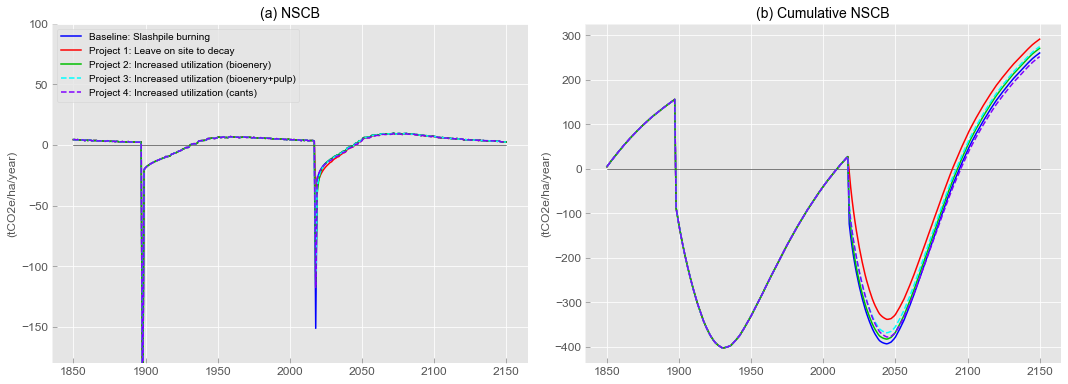

In [21]:
# Plot net sector carbon balance
fig,ax=plt.subplots(1,2,figsize=(15,5.5))

ax[0].plot(v.tv,0*np.ones(v.tv.shape),'-',linewidth=0.5,color=(0,0,0))
ax[0].plot(v.tv,v.Sec_NCB[:,0],'-',color=(0,0,1),label='Baseline: Slashpile burning')
ax[0].plot(v.tv,v.Sec_NCB[:,1],'-',color=(1,0,0),label='Project 1: Leave on site to decay')
ax[0].plot(v.tv,v.Sec_NCB[:,2],'-',color=(0,0.75,0),label='Project 2: Increased utilization (bioenery)')
ax[0].plot(v.tv,v.Sec_NCB[:,3],'--',color=(0,1,1),label='Project 3: Increased utilization (bioenery+pulp)')
ax[0].plot(v.tv,v.Sec_NCB[:,5],'--',color=(0.5,0,1),label='Project 4: Increased utilization (cants)')
ax[0].legend(loc="upper left", prop={'size':10})
ax[0].set_title('(a) NSCB')
ax[0].set_ylim(bottom=-180,top=100)

ax[1].plot(v.tv,0*np.ones(v.tv.shape),'-',linewidth=0.5,color=(0,0,0))
ax[1].plot(v.tv,np.cumsum(v.Sec_NCB[:,0]),'-',color=(0,0,1),label='Baseline')
ax[1].plot(v.tv,np.cumsum(v.Sec_NCB[:,1]),'-',color=(1,0,0),label='Project')
ax[1].plot(v.tv,np.cumsum(v.Sec_NCB[:,2]),'-',color=(0,0.75,0),label='Project')
ax[1].plot(v.tv,np.cumsum(v.Sec_NCB[:,3]),'--',color=(0,1,1),label='Project')
ax[1].plot(v.tv,np.cumsum(v.Sec_NCB[:,5]),'--',color=(0.5,0,1),label='Project')
ax[1].set_title('(b) Cumulative NSCB')

ax[0].set(ylabel=r'(tCO2e/ha/year)');
ax[1].set(ylabel=r'(tCO2e/ha/year)');
plt.tight_layout();

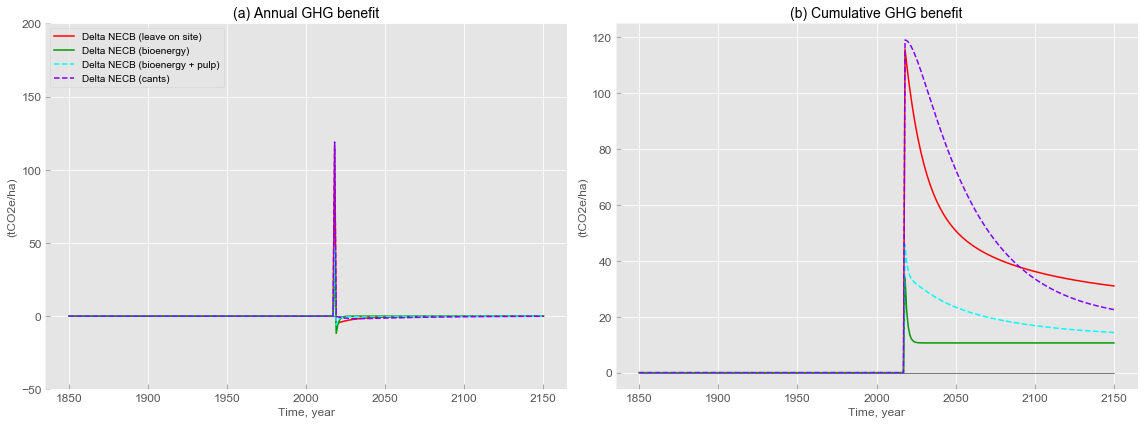

In [22]:
# Plot GHG benefit
fig,ax=plt.subplots(1,2,figsize=(16,6))
plt.rcParams.update({'font.size':10})
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

ax[0].plot(v.tv,0*np.ones(v.tv.shape),'-',linewidth=0.5,color=(0,0,0))
ax[0].plot(v.tv,v.Sec_NCB[:,1]-v.Sec_NCB[:,0],'-',color=(1,0,0),label='Delta NECB (leave on site)')
ax[0].plot(v.tv,v.Sec_NCB[:,2]-v.Sec_NCB[:,0],'-',color=(0,0.6,0),label='Delta NECB (bioenergy)')
ax[0].plot(v.tv,v.Sec_NCB[:,3]-v.Sec_NCB[:,0],'--',color=(0,1,1),label='Delta NECB (bioenergy + pulp)')
ax[0].plot(v.tv,v.Sec_NCB[:,5]-v.Sec_NCB[:,4],'--',color=(0.5,0,1),label='Delta NECB (cants)')
ax[0].legend(loc="upper left", prop={'size': 10})
ax[0].set_title('(a) Annual GHG benefit')
ax[0].set_ylim(bottom=-50,top=200)

ax[1].plot(v.tv,0*np.ones(v.tv.shape),'-',linewidth=0.5,color=(0,0,0))
ax[1].plot(v.tv,np.cumsum(v.Sec_NCB[:,1])-np.cumsum(v.Sec_NCB[:,0]),'-',color=(1,0,0),label='Delta cumulative NECB')
ax[1].plot(v.tv,np.cumsum(v.Sec_NCB[:,2])-np.cumsum(v.Sec_NCB[:,0]),'-',color=(0,0.6,0),label='Delta cumulative NECB')
ax[1].plot(v.tv,np.cumsum(v.Sec_NCB[:,3])-np.cumsum(v.Sec_NCB[:,0]),'--',color=(0,1,1),label='Delta cumulative NECB')
ax[1].plot(v.tv,np.cumsum(v.Sec_NCB[:,5])-np.cumsum(v.Sec_NCB[:,4]),'--',color=(0.5,0,1),label='Delta cumulative NECB')
ax[1].set_title('(b) Cumulative GHG benefit')

ax[0].set(ylabel=r'(tCO2e/ha)');
ax[1].set(ylabel=r'(tCO2e/ha)');
ax[0].set(xlabel=r'Time, year');
ax[1].set(xlabel=r'Time, year');
plt.tight_layout();

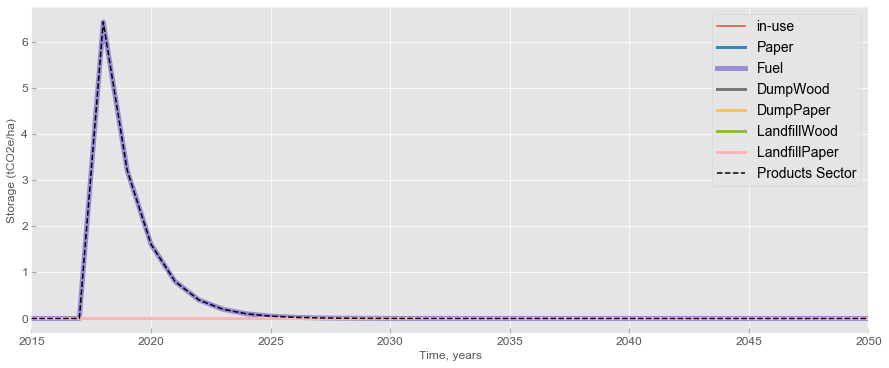

In [23]:
# Look at the residence of fibre in the HWP pools
fig,ax=plt.subplots(1,figsize=(15,6))
plt.rcParams["figure.figsize"]=(20,10)
plt.rcParams.update({'font.size': 12})
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

ax.plot(meta['Time'],np.sum(vo.C_Pro_Pools[:,2,0:7],axis=1)-np.sum(vo.C_Pro_Pools[:,0,0:7],axis=1),label='in-use')
ax.plot(meta['Time'],vo.C_Pro_Pools[:,2,7]-vo.C_Pro_Pools[:,0,7],linewidth=3,label='Paper')
ax.plot(meta['Time'],vo.C_Pro_Pools[:,2,8]-vo.C_Pro_Pools[:,0,8],linewidth=5,label='Fuel')
ax.plot(meta['Time'],vo.C_Pro_Pools[:,2,11]-vo.C_Pro_Pools[:,0,11],linewidth=3,label='DumpWood')
ax.plot(meta['Time'],vo.C_Pro_Pools[:,2,12]-vo.C_Pro_Pools[:,0,12],linewidth=3,label='DumpPaper')
ax.plot(meta['Time'],np.sum(vo.C_Pro_Pools[:,2,13:15],axis=1)-np.sum(vo.C_Pro_Pools[:,0,13:15],axis=1),linewidth=3,label='LandfillWood')
ax.plot(meta['Time'],np.sum(vo.C_Pro_Pools[:,2,15:17],axis=1)-np.sum(vo.C_Pro_Pools[:,0,15:17],axis=1),linewidth=3,label='LandfillPaper')
ax.plot(meta['Time'],np.sum(vo.C_Pro_Pools[:,2,0:17],axis=1)-np.sum(vo.C_Pro_Pools[:,0,0:17],axis=1),'--',label='Products Sector',color='black')
ax.set_xlim(left=2015,right=2050);  
ax.set(xlabel=r'Time, years');
ax.set(ylabel=r'Storage (tCO2e/ha)');
ax.legend(loc="upper right",prop={'size': 14});

In [24]:
# Calculate the m3/ha in slash that is being removed in the projects
j=0
c2dm=2
dm2v=1/0.465
RemMerch=c2dm*dm2v*np.sum(vo.C_RemovedMerch,axis=0)
RemNonMerch=c2dm*dm2v*np.sum(vo.C_RemovedNonMerch,axis=0)
RemSnag=c2dm*dm2v*np.sum(vo.C_RemovedSnagStem,axis=0)
RemTotal=RemMerch+RemNonMerch+RemSnag

df=pd.DataFrame(columns=['Variable','Baseline','Leave on site','Bioenergy','Bioenergy+Pulp','Cants baseline','Cants'])
df['Variable']=['Merch. stemwood (m3/ha)','Nonmerch. stemwood (m3/ha)','Snag stemwood (m3/ha)','Total (m3/ha)']
df.iloc[0,1:]=np.round(RemMerch)
df.iloc[1,1:]=np.round(RemNonMerch)
df.iloc[2,1:]=np.round(RemSnag)
df.iloc[3,1:]=np.round(RemTotal)
df

,Variable,Baseline,Leave on site,Bioenergy,Bioenergy+Pulp,Cants baseline,Cants
0,Merch. stemwood (m3/ha),348,348,348,348,265,379
1,Nonmerch. stemwood (m3/ha),0,0,36,36,0,0
2,Snag stemwood (m3/ha),0,0,19,19,0,0
3,Total (m3/ha),348,348,404,404,265,379


In [25]:
# Tabulate results
df=pd.DataFrame(columns=['Variable','Leave on site','Bioenergy','Bioenergy+Pulp','Cants'])

df['Variable']=['Fibre removed (m3/ha)', \
                'Annual GHG benefit 2030 (tCO2e/ha/yr)','Cumulative GHG benefit 2030 (tCO2e/ha)', \
                'Annual GHG benefit 2050 (tCO2e/ha/yr)','Cumulative GHG benefit 2050 (tCO2e/ha)', \
                'Annual GHG benefit 2070 (tCO2e/ha/yr)','Cumulative GHG benefit 2070 (tCO2e/ha)', \
                'Cost ($/ha)', \
                'Cost efficiency 2050 ($/tCO2e)']

# Fibre removed
df['Leave on site'].iloc[0]=np.round(RemTotal[1]-RemTotal[0],decimals=1)
df['Bioenergy'].iloc[0]=np.round(RemTotal[2]-RemTotal[0],decimals=1)
df['Bioenergy+Pulp'].iloc[0]=np.round(RemTotal[3]-RemTotal[0],decimals=1)
df['Cants'].iloc[0]=np.round(RemTotal[5]-RemTotal[4],decimals=1)

# GHG benefit
dA=v.Sec_NCB[:,1]-v.Sec_NCB[:,0]; dC=np.cumsum(v.Sec_NCB[:,1])-np.cumsum(v.Sec_NCB[:,0])
it=np.where(v.tv==2030)[0]; dA30=dA[it][0]; dC30=dC[it][0]
it=np.where(v.tv==2050)[0]; dA50=dA[it][0]; dC50=dC[it][0]
it=np.where(v.tv==2070)[0]; dA70=dA[it][0]; dC70=dC[it][0]
df['Leave on site'].iloc[1]=np.round(dA30,decimals=1)
df['Leave on site'].iloc[2]=np.round(dC30,decimals=1)
df['Leave on site'].iloc[3]=np.round(dA50,decimals=1)
df['Leave on site'].iloc[4]=np.round(dC50,decimals=1)
df['Leave on site'].iloc[5]=np.round(dA70,decimals=1)
df['Leave on site'].iloc[6]=np.round(dC70,decimals=1)

dA=v.Sec_NCB[:,2]-v.Sec_NCB[:,0]; dC=np.cumsum(v.Sec_NCB[:,2])-np.cumsum(v.Sec_NCB[:,0])
it=np.where(v.tv==2030)[0]; dA30=dA[it][0]; dC30=dC[it][0]
it=np.where(v.tv==2050)[0]; dA50=dA[it][0]; dC50=dC[it][0]
it=np.where(v.tv==2070)[0]; dA70=dA[it][0]; dC70=dC[it][0]
df['Bioenergy'].iloc[1]=np.round(dA30,decimals=1)
df['Bioenergy'].iloc[2]=np.round(dC30,decimals=1)
df['Bioenergy'].iloc[3]=np.round(dA50,decimals=1)
df['Bioenergy'].iloc[4]=np.round(dC50,decimals=1)
df['Bioenergy'].iloc[5]=np.round(dA70,decimals=1)
df['Bioenergy'].iloc[6]=np.round(dC70,decimals=1)

dA=v.Sec_NCB[:,3]-v.Sec_NCB[:,0]; dC=np.cumsum(v.Sec_NCB[:,3])-np.cumsum(v.Sec_NCB[:,0])
it=np.where(v.tv==2030)[0]; dA30=dA[it][0]; dC30=dC[it][0]
it=np.where(v.tv==2050)[0]; dA50=dA[it][0]; dC50=dC[it][0]
it=np.where(v.tv==2070)[0]; dA70=dA[it][0]; dC70=dC[it][0]
df['Bioenergy+Pulp'].iloc[1]=np.round(dA30,decimals=1)
df['Bioenergy+Pulp'].iloc[2]=np.round(dC30,decimals=1)
df['Bioenergy+Pulp'].iloc[3]=np.round(dA50,decimals=1)
df['Bioenergy+Pulp'].iloc[4]=np.round(dC50,decimals=1)
df['Bioenergy+Pulp'].iloc[5]=np.round(dA70,decimals=1)
df['Bioenergy+Pulp'].iloc[6]=np.round(dC70,decimals=1)

dA=v.Sec_NCB[:,5]-v.Sec_NCB[:,4]; dC=np.cumsum(v.Sec_NCB[:,5])-np.cumsum(v.Sec_NCB[:,4])
it=np.where(v.tv==2030)[0]; dA30=dA[it][0]; dC30=dC[it][0]
it=np.where(v.tv==2050)[0]; dA50=dA[it][0]; dC50=dC[it][0]
it=np.where(v.tv==2070)[0]; dA70=dA[it][0]; dC70=dC[it][0]
df['Cants'].iloc[1]=np.round(dA30,decimals=1)
df['Cants'].iloc[2]=np.round(dC30,decimals=1)
df['Cants'].iloc[3]=np.round(dA50,decimals=1)
df['Cants'].iloc[4]=np.round(dC50,decimals=1)
df['Cants'].iloc[5]=np.round(dA70,decimals=1)
df['Cants'].iloc[6]=np.round(dC70,decimals=1)

# Cost
df['Leave on site'].iloc[7]=np.round(cost_los,decimals=2)
df['Bioenergy'].iloc[7]=np.round(df['Bioenergy'].iloc[0]*cost_per_km_per_m3*distance,decimals=2)
df['Bioenergy+Pulp'].iloc[7]=np.round(df['Bioenergy+Pulp'].iloc[0]*cost_per_km_per_m3*distance,decimals=2)
df['Cants'].iloc[7]=np.round(df['Cants'].iloc[0]*cost_per_km_per_m3*distance,decimals=2)

# Cost efficiency
df['Leave on site'].iloc[8]=np.round(df['Leave on site'].iloc[7]/df['Leave on site'].iloc[4],decimals=0)
df['Bioenergy'].iloc[8]=np.round(df['Bioenergy'].iloc[7]/df['Bioenergy'].iloc[4],decimals=0)
df['Bioenergy+Pulp'].iloc[8]=np.round(df['Bioenergy+Pulp'].iloc[7]/df['Bioenergy+Pulp'].iloc[4],decimals=0)
df['Cants'].iloc[8]=np.round(df['Cants'].iloc[7]/df['Cants'].iloc[4],decimals=0)

df

,Variable,Leave on site,Bioenergy,Bioenergy+Pulp,Cants
0,Fibre removed (m3/ha),0,55.3,55.3,113.6
1,Annual GHG benefit 2030 (tCO2e/ha/yr),-2.2,-0,-0.4,-1.7
2,Cumulative GHG benefit 2030 (tCO2e/ha),74.4,10.6,29.7,104.6
3,Annual GHG benefit 2050 (tCO2e/ha/yr),-0.6,-0,-0.2,-1.4
4,Cumulative GHG benefit 2050 (tCO2e/ha),50.8,10.6,23.4,72.6
5,Annual GHG benefit 2070 (tCO2e/ha/yr),-0.3,-0,-0.1,-0.8
6,Cumulative GHG benefit 2070 (tCO2e/ha),42.4,10.6,19.9,51.1
7,Cost ($/ha),92.5,192.77,192.77,395.99
8,Cost efficiency 2050 ($/tCO2e),2,18,8,5


## Export GHG benefit for FCI database

In [37]:
df=pd.DataFrame(columns=['Time','Leave on Site','Bioenergy','Bioenergy and Pulp','Cants'])
it=np.where(v.tv>=1990)[0]
df['Time']=v.tv[it]
df['Leave on Site']=np.round(v.Sec_NCB[it,1]-v.Sec_NCB[it,0],2)
df['Bioenergy']=np.round(v.Sec_NCB[it,2]-v.Sec_NCB[it,0],2)
df['Bioenergy and Pulp']=np.round(v.Sec_NCB[it,3]-v.Sec_NCB[it,0],2)
df['Cants']=np.round(v.Sec_NCB[it,4]-v.Sec_NCB[it,0],2)
df.to_excel(meta['Path Project'] + '\\Outputs\\Ensembles\\E0\\AnnualGHGBenefitSummary.xlsx',index=False)